In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from polygon import RESTClient
import json
import time
from sklearn.linear_model import LinearRegression
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# Function to get data for a single ticker
def getTickerDailyData(client, ticker="IBM", start="2023-01-01", end="2023-02-01"):
    print(f'Starting data pull for {ticker}...')
    data = []
    date_range = pd.date_range(start, end, freq='B')

    for business_day in date_range:
        try:
            response = client.stocks_equities_daily_open_close(symbol=ticker, date=str(business_day)[0:10])
            data.append([pd.to_datetime(response.from_) ,response.open, response.close, response.high, response.low, ticker])
        except:
            continue
    print(f'Ended data pull for {ticker}...')
    return pd.DataFrame(data, columns=['date', 'open', 'close', 'high', 'low', 'ticker'])


In [3]:
# Get data from start_date to end_date for the ticker

client = RESTClient(auth_key="JeeOjlOPBe5aTiQ_Jb39raRqlam45uAO")
ticker = "EZPW"
start_date = "2018-01-01"
end_date = "2023-02-01"

ezpw_data = getTickerDailyData(client, ticker=ticker, start=start_date, end=end_date)

Starting data pull for EZPW...
Ended data pull for EZPW...


In [68]:
# Function that takes in two values from the ticker data and plots them

def createPlot(xvalue, yvalue, xlabel, ylabel, title, xvalue2=np.empty(0), yvalue2=np.empty(0)):
    fig, ax = plt.subplots()
    ax.plot(xvalue, yvalue)
    if xvalue2.size > 0:
        ax.plot(xvalue2, yvalue2)

    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
   
        
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.grid()
    fig.tight_layout()
    plt.show()

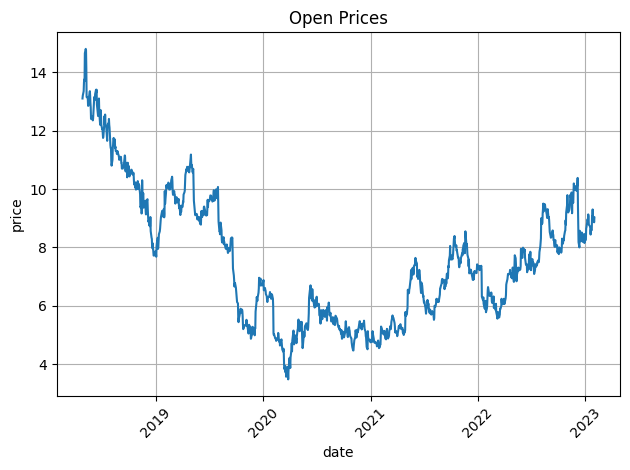

In [69]:
# Plot our Open proces from 2018-01-01 to 2023-02-01

createPlot(xvalue=ezpw_data.date.values, yvalue=ezpw_data.open.values, xlabel="date", ylabel="price", title="Open Prices")

 Build Model

Our first model, will be a SA-ARISMA model using only the series itself, predicting one day in advance then incorporating that data into its next daily prediction. Seasonally Adjusted, Autoregressive, Integrated, Simple moving average model. 

In [84]:
# Get a sample of our opening prices

ezpw_data_open = ezpw_data[['date', 'open', 'ticker']]
ezpw_data_open.head()

date   open ticker
0 2018-04-26 13.100   EZPW
1 2018-04-27 13.200   EZPW
2 2018-04-30 13.350   EZPW
3 2018-05-01 13.650   EZPW
4 2018-05-02 13.750   EZPW

In [92]:
# Creating our parameters for our model

ezpw_data_open["ar1"] = ezpw_data_open['open'].shift(1)
ezpw_data_open["ar2"] = ezpw_data_open['open'].shift(2)
ezpw_data_open["ar3"] = ezpw_data_open['open'].shift(3)
ezpw_data_open["ar4"] = ezpw_data_open['open'].shift(4)
ezpw_data_open["SMA"] = ezpw_data_open['ar1'].rolling(5).mean()
ezpw_data_open["int"] = ezpw_data_open.ar1 - ezpw_data_open.ar2
ezpw_data_open['intercept'] = np.ones(len(ezpw_data_open))

ezpw_data_open.head()

date   open ticker    ar1    ar2    ar3    ar4  SMA   int  intercept
0 2018-04-26 13.100   EZPW    NaN    NaN    NaN    NaN  NaN   NaN      1.000
1 2018-04-27 13.200   EZPW 13.100    NaN    NaN    NaN  NaN   NaN      1.000
2 2018-04-30 13.350   EZPW 13.200 13.100    NaN    NaN  NaN 0.100      1.000
3 2018-05-01 13.650   EZPW 13.350 13.200 13.100    NaN  NaN 0.150      1.000
4 2018-05-02 13.750   EZPW 13.650 13.350 13.200 13.100  NaN 0.300      1.000

In [93]:
# Checking the shape of our data

ezpw_data_open.shape

(1201, 10)

In [94]:
# We removed the first 5 indexes in the data set due to Null values in the paraments

train_data = ezpw_data_open[5:500]
train_data.head()

date   open ticker    ar1    ar2    ar3    ar4    SMA    int  \
5 2018-05-03 13.700   EZPW 13.750 13.650 13.350 13.200 13.410  0.100   
6 2018-05-04 14.650   EZPW 13.700 13.750 13.650 13.350 13.530 -0.050   
7 2018-05-07 14.800   EZPW 14.650 13.700 13.750 13.650 13.820  0.950   
8 2018-05-08 14.750   EZPW 14.800 14.650 13.700 13.750 14.110  0.150   
9 2018-05-09 14.150   EZPW 14.750 14.800 14.650 13.700 14.330 -0.050   

   intercept  
5      1.000  
6      1.000  
7      1.000  
8      1.000  
9      1.000

In [121]:
# Using Linear Regression function to fit our model
reg = LinearRegression()
fit_model = reg.fit(train_data[['ar1','ar2', 'SMA', 'int']], train_data[['open']])

In [122]:
fit_model.coef_

array([[0.66380297, 0.28418456, 0.04715508, 0.37961841]])

In [123]:
fit_model.intercept_

array([0.02462395])

In [124]:
fit_model.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [125]:
# Added our insample prediction for each day to our training data set

train_data['prediction_insample'] = fit_model.predict(train_data[['ar1','ar2', 'SMA', 'int']])
train_data.head()

/var/folders/wf/0c6sjv6d37v2hjz6__lc87lw0000gn/T/ipykernel_16385/3590776548.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['prediction_insample'] = fit_model.predict(train_data[['ar1','ar2', 'SMA', 'int']])


date   open ticker    ar1    ar2    ar3    ar4    SMA    int  \
5 2018-05-03 13.700   EZPW 13.750 13.650 13.350 13.200 13.410  0.100   
6 2018-05-04 14.650   EZPW 13.700 13.750 13.650 13.350 13.530 -0.050   
7 2018-05-07 14.800   EZPW 14.650 13.700 13.750 13.650 13.820  0.950   
8 2018-05-08 14.750   EZPW 14.800 14.650 13.700 13.750 14.110  0.150   
9 2018-05-09 14.150   EZPW 14.750 14.800 14.650 13.700 14.330 -0.050   

   intercept  prediction_insample  error  sq_error  abs_error  
5      1.000               13.701 -0.001     0.000      0.001  
6      1.000               13.645  1.005     1.009      1.005  
7      1.000               14.655  0.145     0.021      0.145  
8      1.000               14.735  0.015     0.000      0.015  
9      1.000               14.678 -0.528     0.279      0.528

In [106]:
# Adding our error, squared error and absolute error to our training data set

train_data['error'] = train_data.open - train_data.prediction_insample
train_data['sq_error'] = train_data['error']**2
train_data['abs_error'] = np.abs(train_data['error'])

train_data

/var/folders/wf/0c6sjv6d37v2hjz6__lc87lw0000gn/T/ipykernel_16385/2976424783.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['error'] = train_data.open - train_data.prediction_insample
/var/folders/wf/0c6sjv6d37v2hjz6__lc87lw0000gn/T/ipykernel_16385/2976424783.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['sq_error'] = train_data['error']**2
/var/folders/wf/0c6sjv6d37v2hjz6__lc87lw0000gn/T/ipykernel_16385/2976424783.py:4: SettingWithCopyWarning: 
A value is trying to be set on

date   open ticker    ar1    ar2    ar3    ar4    SMA    int  \
5   2018-05-03 13.700   EZPW 13.750 13.650 13.350 13.200 13.410  0.100   
6   2018-05-04 14.650   EZPW 13.700 13.750 13.650 13.350 13.530 -0.050   
7   2018-05-07 14.800   EZPW 14.650 13.700 13.750 13.650 13.820  0.950   
8   2018-05-08 14.750   EZPW 14.800 14.650 13.700 13.750 14.110  0.150   
9   2018-05-09 14.150   EZPW 14.750 14.800 14.650 13.700 14.330 -0.050   
..         ...    ...    ...    ...    ...    ...    ...    ...    ...   
495 2020-04-15  4.680   EZPW  4.870  5.151  4.810  4.440  4.798 -0.280   
496 2020-04-16  4.820   EZPW  4.680  4.870  5.151  4.810  4.790 -0.190   
497 2020-04-17  5.000   EZPW  4.820  4.680  4.870  5.151  4.866  0.140   
498 2020-04-20  4.830   EZPW  5.000  4.820  4.680  4.870  4.904  0.180   
499 2020-04-21  4.760   EZPW  4.830  5.000  4.820  4.680  4.840 -0.170   

     intercept  prediction_insample  error  sq_error  abs_error  
5        1.000               13.701 -0.001     0.000      0.001  
6        1.000               13.645  1.005     1.009      1.005  
7        1.000               14.655  0.145     0.021      0.145  
8        1.000               14.735  0.015     0.000      0.015  
9        1.000               14.678 -0.528     0.279      0.528  
..         ...                  ...    ...       ...        ...  
495      1.000                4.841 -0.161     0.026      0.161  
496      1.000                4.669  0.151     0.023      0.151  
497      1.000                4.837  0.163     0.027      0.163  
498      1.000                5.013 -0.183     0.033      0.183  
499      1.000                4.815 -0.055     0.003      0.055  

[495 rows x 14 columns]

In [108]:
# Returns the mean for error, squared error and absolute error for the training set

train_data[['error', 'sq_error', 'abs_error']].mean()

error       0.000
sq_error    0.047
abs_error   0.157
dtype: float64

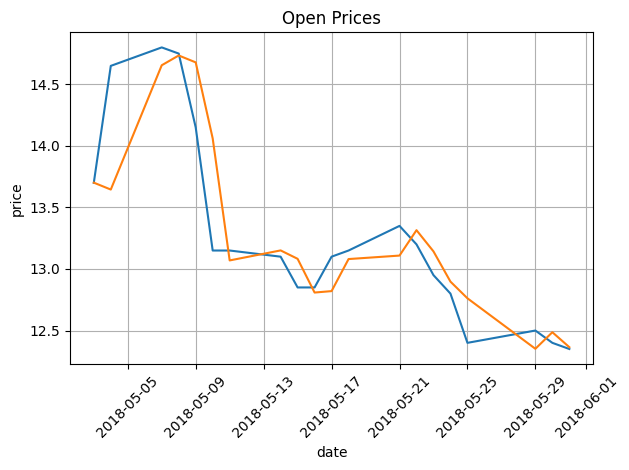

In [70]:
# Ploting our Model verses the training data

train_data_date_values = train_data.date.values[:20]
train_data_open_values = train_data.open.values[:20]
train_data_date_values = train_data.date.values[:20]
train_data_prediction_insample_values = train_data.prediction_insample.values[:20]


createPlot(xvalue=train_data_date_values, 
           yvalue=train_data_open_values, 
           xlabel='date', 
           ylabel='price', 
           title="Open Prices",
           xvalue2=train_data_date_values,
           yvalue2=train_data_prediction_insample_values
           )

In [110]:
# Creating our test data set

test_data = ezpw_data_open[500:]
test_data

date  open ticker   ar1   ar2   ar3   ar4   SMA    int  intercept
500  2020-04-22 4.900   EZPW 4.760 4.830 5.000 4.820 4.818 -0.070      1.000
501  2020-04-23 4.720   EZPW 4.900 4.760 4.830 5.000 4.862  0.140      1.000
502  2020-04-24 4.920   EZPW 4.720 4.900 4.760 4.830 4.842 -0.180      1.000
503  2020-04-27 5.180   EZPW 4.920 4.720 4.900 4.760 4.826  0.200      1.000
504  2020-04-28 5.210   EZPW 5.180 4.920 4.720 4.900 4.896  0.260      1.000
...         ...   ...    ...   ...   ...   ...   ...   ...    ...        ...
1196 2023-01-26 9.300   EZPW 9.090 9.080 8.590 8.610 8.762  0.010      1.000
1197 2023-01-27 9.070   EZPW 9.300 9.090 9.080 8.590 8.934  0.210      1.000
1198 2023-01-30 9.030   EZPW 9.070 9.300 9.090 9.080 9.026 -0.230      1.000
1199 2023-01-31 8.860   EZPW 9.030 9.070 9.300 9.090 9.114 -0.040      1.000
1200 2023-02-01 9.020   EZPW 8.860 9.030 9.070 9.300 9.070 -0.170      1.000

[701 rows x 10 columns]

In [113]:
# Fiting our model to the test data set and dadding our predictions to the test data set

test_data['prediction_oos'] = fit_model.predict(test_data[['ar1','ar2', 'SMA', 'int']])

test_data.head()

/var/folders/wf/0c6sjv6d37v2hjz6__lc87lw0000gn/T/ipykernel_16385/3053120577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction_oos'] = fit_model.predict(test_data[['ar1','ar2', 'SMA', 'int']])


date  open ticker   ar1   ar2   ar3   ar4   SMA    int  intercept  \
500 2020-04-22 4.900   EZPW 4.760 4.830 5.000 4.820 4.818 -0.070      1.000   
501 2020-04-23 4.720   EZPW 4.900 4.760 4.830 5.000 4.862  0.140      1.000   
502 2020-04-24 4.920   EZPW 4.720 4.900 4.760 4.830 4.842 -0.180      1.000   
503 2020-04-27 5.180   EZPW 4.920 4.720 4.900 4.760 4.826  0.200      1.000   
504 2020-04-28 5.210   EZPW 5.180 4.920 4.720 4.900 4.896  0.260      1.000   

     prediction_oos  
500           4.758  
501           4.912  
502           4.710  
503           4.935  
504           5.191

In [114]:
# Adding our error, squared error and absolute error to our test data set

test_data['error'] = test_data.open - test_data.prediction_oos
test_data['sq_error'] = test_data['error']**2
test_data['abs_error'] = np.abs(test_data['error'])

test_data

/var/folders/wf/0c6sjv6d37v2hjz6__lc87lw0000gn/T/ipykernel_16385/3432426920.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['error'] = test_data.open - test_data.prediction_oos
/var/folders/wf/0c6sjv6d37v2hjz6__lc87lw0000gn/T/ipykernel_16385/3432426920.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['sq_error'] = test_data['error']**2
/var/folders/wf/0c6sjv6d37v2hjz6__lc87lw0000gn/T/ipykernel_16385/3432426920.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of

date  open ticker   ar1   ar2   ar3   ar4   SMA    int  intercept  \
500  2020-04-22 4.900   EZPW 4.760 4.830 5.000 4.820 4.818 -0.070      1.000   
501  2020-04-23 4.720   EZPW 4.900 4.760 4.830 5.000 4.862  0.140      1.000   
502  2020-04-24 4.920   EZPW 4.720 4.900 4.760 4.830 4.842 -0.180      1.000   
503  2020-04-27 5.180   EZPW 4.920 4.720 4.900 4.760 4.826  0.200      1.000   
504  2020-04-28 5.210   EZPW 5.180 4.920 4.720 4.900 4.896  0.260      1.000   
...         ...   ...    ...   ...   ...   ...   ...   ...    ...        ...   
1196 2023-01-26 9.300   EZPW 9.090 9.080 8.590 8.610 8.762  0.010      1.000   
1197 2023-01-27 9.070   EZPW 9.300 9.090 9.080 8.590 8.934  0.210      1.000   
1198 2023-01-30 9.030   EZPW 9.070 9.300 9.090 9.080 9.026 -0.230      1.000   
1199 2023-01-31 8.860   EZPW 9.030 9.070 9.300 9.090 9.114 -0.040      1.000   
1200 2023-02-01 9.020   EZPW 8.860 9.030 9.070 9.300 9.070 -0.170      1.000   

      prediction_oos  error  sq_error  abs_error  
500            4.758  0.142     0.020      0.142  
501            4.912 -0.192     0.037      0.192  
502            4.710  0.210     0.044      0.210  
503            4.935  0.245     0.060      0.245  
504            5.191  0.019     0.000      0.019  
...              ...    ...       ...        ...  
1196           9.056  0.244     0.060      0.244  
1197           9.282 -0.212     0.045      0.212  
1198           9.027  0.003     0.000      0.003  
1199           9.011 -0.151     0.023      0.151  
1200           8.835  0.185     0.034      0.185  

[701 rows x 14 columns]

In [30]:
# Returns the mean for error, squared error and absolute error for the training set

test_data[['error', 'sq_error', 'abs_error']].mean()

error       0.014
sq_error    0.034
abs_error   0.136
dtype: float64

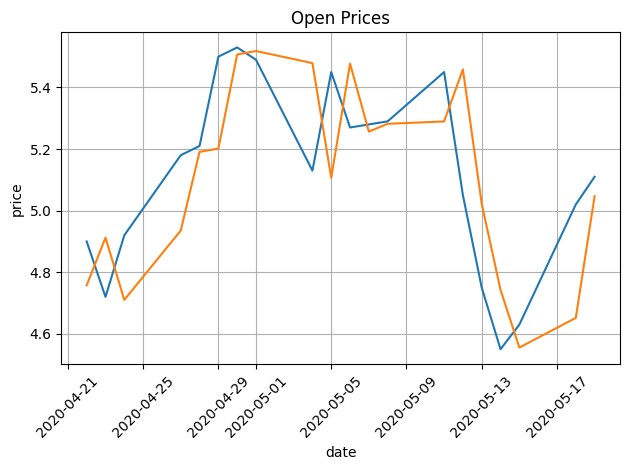

In [115]:
# Ploting our Model verses the test data

test_data_date_values = test_data.date.values[:20]
test_data_open_values = test_data.open.values[:20]
test_data_date_values = test_data.date.values[:20]
test_data_prediction_oos_values = test_data.prediction_oos.values[:20]


createPlot(xvalue=test_data_date_values, 
           yvalue=test_data_open_values, 
           xlabel='date', 
           ylabel='price', 
           title="Open Prices",
           xvalue2=test_data_date_values,
           yvalue2=test_data_prediction_oos_values
           )

In [116]:
fit_model2 = reg.fit(test_data[['ar1','ar2', 'SMA', 'int']], test_data[['open']])

In [117]:
test_data['prediction_inSample']= fit_model2.predict(test_data[['ar1','ar2', 'SMA', 'int']])

/var/folders/wf/0c6sjv6d37v2hjz6__lc87lw0000gn/T/ipykernel_16385/832968439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction_inSample']= fit_model2.predict(test_data[['ar1','ar2', 'SMA', 'int']])


In [118]:
test_data

date  open ticker   ar1   ar2   ar3   ar4   SMA    int  intercept  \
500  2020-04-22 4.900   EZPW 4.760 4.830 5.000 4.820 4.818 -0.070      1.000   
501  2020-04-23 4.720   EZPW 4.900 4.760 4.830 5.000 4.862  0.140      1.000   
502  2020-04-24 4.920   EZPW 4.720 4.900 4.760 4.830 4.842 -0.180      1.000   
503  2020-04-27 5.180   EZPW 4.920 4.720 4.900 4.760 4.826  0.200      1.000   
504  2020-04-28 5.210   EZPW 5.180 4.920 4.720 4.900 4.896  0.260      1.000   
...         ...   ...    ...   ...   ...   ...   ...   ...    ...        ...   
1196 2023-01-26 9.300   EZPW 9.090 9.080 8.590 8.610 8.762  0.010      1.000   
1197 2023-01-27 9.070   EZPW 9.300 9.090 9.080 8.590 8.934  0.210      1.000   
1198 2023-01-30 9.030   EZPW 9.070 9.300 9.090 9.080 9.026 -0.230      1.000   
1199 2023-01-31 8.860   EZPW 9.030 9.070 9.300 9.090 9.114 -0.040      1.000   
1200 2023-02-01 9.020   EZPW 8.860 9.030 9.070 9.300 9.070 -0.170      1.000   

      prediction_oos  error  sq_error  abs_error  prediction_inSample  
500            4.758  0.142     0.020      0.142                4.782  
501            4.912 -0.192     0.037      0.192                4.918  
502            4.710  0.210     0.044      0.210                4.743  
503            4.935  0.245     0.060      0.245                4.938  
504            5.191  0.019     0.000      0.019                5.195  
...              ...    ...       ...        ...                  ...  
1196           9.056  0.244     0.060      0.244                9.077  
1197           9.282 -0.212     0.045      0.212                9.283  
1198           9.027  0.003     0.000      0.003                9.059  
1199           9.011 -0.151     0.023      0.151                9.018  
1200           8.835  0.185     0.034      0.185                8.851  

[701 rows x 15 columns]

In [119]:
test_data['in_sample_error'] = test_data.open - test_data.prediction_inSample
test_data['in_sample_sq_error'] = test_data['in_sample_error']**2
test_data['in_sample_abs_error'] = np.abs(test_data['in_sample_error'])

/var/folders/wf/0c6sjv6d37v2hjz6__lc87lw0000gn/T/ipykernel_16385/1595241562.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['in_sample_error'] = test_data.open - test_data.prediction_inSample
/var/folders/wf/0c6sjv6d37v2hjz6__lc87lw0000gn/T/ipykernel_16385/1595241562.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['in_sample_sq_error'] = test_data['in_sample_error']**2
/var/folders/wf/0c6sjv6d37v2hjz6__lc87lw0000gn/T/ipykernel_16385/1595241562.py:3: SettingWithCopyWarning: 
A val

In [120]:
test_data[['in_sample_error', 'in_sample_sq_error', 'in_sample_abs_error']].mean()

in_sample_error       0.000
in_sample_sq_error    0.033
in_sample_abs_error   0.136
dtype: float64